In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import sys
sys.path.insert(0, '../')

import structure_model_lib
import data_utils
import paragami
import structure_optimization_lib

import preconditioner_lib

import time

In [2]:
from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

import os


In [3]:
np.random.seed(53453)

# Load data

In [4]:
n_obs = 40
n_loci = 50
n_pop = 4

# n_obs = 100
# n_loci = 2000
# n_pop = 4


data = np.load('../simulated_data/simulated_structure_data_nobs{}_nloci{}_npop{}.npz'.format(
                n_obs, n_loci, n_pop))

In [5]:
# population allele frequencies
true_pop_allele_freq = data['true_pop_allele_freq']

# individual admixtures
true_ind_admix_propn = data['true_ind_admix_propn']

# observations 
g_obs = data['g_obs']

assert n_obs == g_obs.shape[0]
assert n_loci == g_obs.shape[1]
assert n_pop == true_pop_allele_freq.shape[1]

print('true_number of populations: ', n_pop)

true_number of populations:  4


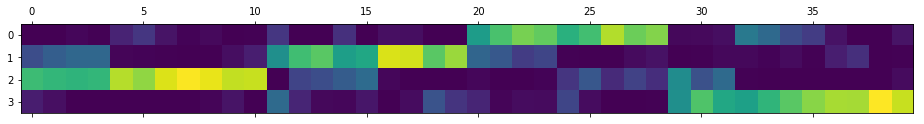

In [6]:
plt.matshow(true_ind_admix_propn.T)

# Load initial fit

In [7]:
init_alpha = 8.0

# load optimal vb parameters at init_alpha
vb_opt_dict, vb_params_paragami, data =\
    paragami.load_folded('../fits/structure_fit_nobs{}_nloci{}_npop{}_alpha{}.npz'.format(
                                n_obs, n_loci, n_pop, init_alpha))

# free optimal vb_parameters
vb_opt_free_params = vb_params_paragami.flatten(vb_opt_dict, free = True)

# load prior parameters
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()
prior_params_dict['dp_prior_alpha'] = data['alpha']

# other parameters
gh_deg = int(data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)
use_logitnormal_sticks = data['use_logitnormal_sticks']

# assert we are at an optimum 
structure_model_lib.assert_optimizer(g_obs, vb_opt_dict, vb_params_paragami, 
                                     prior_params_dict, gh_loc, gh_weights,
                                    use_logitnormal_sticks)

# check results

In [8]:
if use_logitnormal_sticks: 
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_opt_dict['ind_mix_stick_propn_mean'], 
                        vb_opt_dict['ind_mix_stick_propn_info'],
                        gh_loc, gh_weights)

else: 
    ind_mix_stick_beta_params = vb_opt_dict['ind_mix_stick_beta_params']
    e_stick_lengths = \
            modeling_lib.get_e_beta(ind_mix_stick_beta_params)
    e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

e_pop_freq = modeling_lib.get_e_beta(vb_opt_dict['pop_freq_beta_params'])

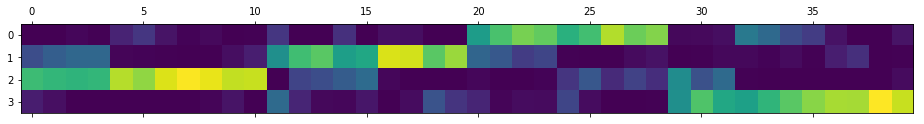

In [9]:
plt.matshow(true_ind_admix_propn.T)

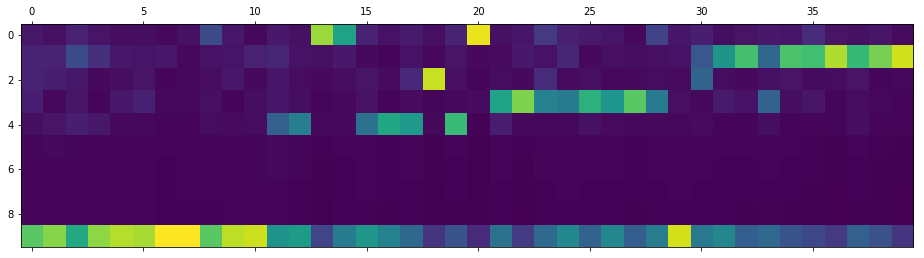

In [10]:
plt.matshow(e_ind_admix.T)

# Parametric sensitivity

## Get linear sensitivity object

In [11]:
get_kl_from_vb_free_prior_free = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

In [12]:
objective_fun = lambda x, y: get_kl_from_vb_free_prior_free(g_obs, x, y, use_logitnormal_sticks, 
                                                                    gh_loc, gh_weights)

In [13]:
vb_obj = np.load('../fits/structure_fit_nobs{}_nloci{}_npop{}_alpha{}_sens_obj.npz'.format(
                    n_obs, n_loci, n_pop, init_alpha))

In [14]:
# whether or not we pre-saved our hessian
load_sens = True

if load_sens: 
    # if we pre-saved our hessian
    vb_obj = vb_obj = np.load('../fits/structure_fit_nobs{}_nloci{}_npop{}_alpha{}_sens_obj.npz'.format(
                    n_obs, n_loci, n_pop, init_alpha))
else:
    vb_obj = {'hessian': None, 'cross_hess': None, 'sens_mat': None}
    
# mfvb_cov, mfvb_info = \
#     preconditioner_lib.get_mfvb_cov_preconditioner(vb_opt_dict, vb_params_paragami,
#                                                     use_logitnormal_sticks)

hvp = autograd.hessian_vector_product(objective_fun, argnum=0)
system_solver = preconditioner_lib.SystemSolverFromHVP(hvp, vb_opt_free_params, 
                        prior_params_paragami.flatten(prior_params_dict, free = True))

In [15]:
t0 = time.time()

vb_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = objective_fun,
        opt_par_value = vb_opt_free_params, 
        hyper_par_value = prior_params_paragami.flatten(prior_params_dict, free=True),
        validate_optimum=False,
        hessian_at_opt=None,
        cross_hess_at_opt=vb_obj['cross_hess'],
        sens_mat = vb_obj['sens_mat'],
        hyper_par_objective_fun=None,
        grad_tol=1e-8, 
        system_solver=system_solver,
        compute_hess=False)
    
print(time.time() - t0)


0.0056340694427490234


In [16]:
# checking the hessian 
# this takes a moment
test_hessian = False
if test_hessian: 
    which_prior = np.array([1., 0., 0.])
    sens_der = structure_optimization_lib.check_hessian(vb_sens, which_prior)
    print(np.max(np.abs(sens_der)))

# Check for a range of alphas

In [17]:
alpha_vec = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [18]:
pert_vb_free_params_array = np.zeros((len(alpha_vec), len(vb_opt_free_params)))
lr_vb_free_params_array = np.zeros((len(alpha_vec), len(vb_opt_free_params)))

for i in range(len(alpha_vec)): 
    fit_file = '../fits/structure_fit_nobs{}_nloci{}_npop{}_alpha{}.npz'.format(
                                n_obs, n_loci, n_pop, alpha_vec[i])
    
    if not os.path.isfile(fit_file): 
        continue 
    
    print(alpha_vec[i])
    # load result    
    vb_pert_opt_dict, _, data = \
        paragami.load_folded('../fits/structure_fit_nobs{}_nloci{}_npop{}_alpha{}.npz'.format(
                                n_obs, n_loci, n_pop, alpha_vec[i]))

    # free optimal vb_parameters
    pert_vb_free_params = vb_params_paragami.flatten(vb_pert_opt_dict, free = True)

    # load prior parameter
    prior_perturbed_dict = deepcopy(prior_params_dict)
    prior_perturbed_dict['dp_prior_alpha'] = data['alpha']

    # assert we are at an optimum 
    structure_model_lib.assert_optimizer(g_obs, vb_pert_opt_dict, vb_params_paragami, 
                                         prior_perturbed_dict, gh_loc, gh_weights,
                                        use_logitnormal_sticks)
    
    # get linear response
    lr_vb_free_params = \
        vb_sens.predict_opt_par_from_hyper_par(
            prior_params_paragami.flatten(prior_perturbed_dict, free = True))
#     lr_vb_free_params = vb_sens.evaluate_taylor_series(prior_params_paragami.flatten(
#                             prior_perturbed_dict, free = True))
    
    pert_vb_free_params_array[i, :] = pert_vb_free_params
    lr_vb_free_params_array[i, :] = lr_vb_free_params
    

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


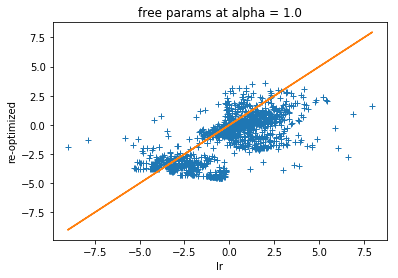

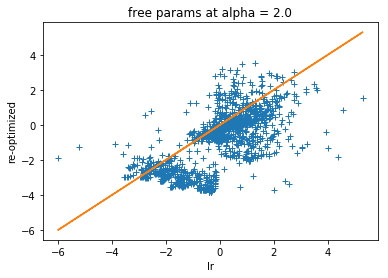

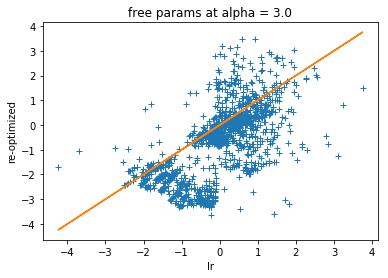

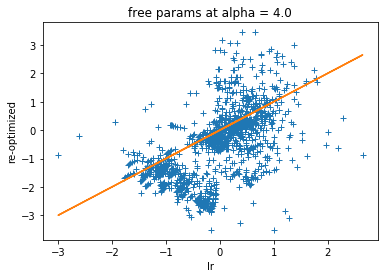

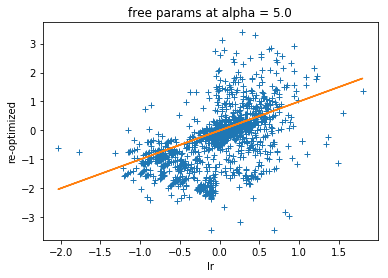

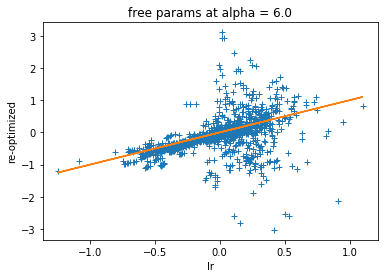

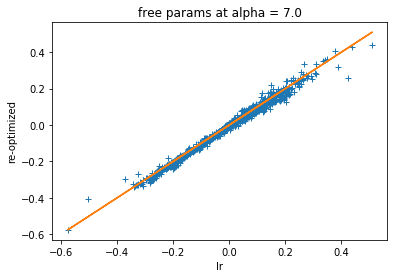

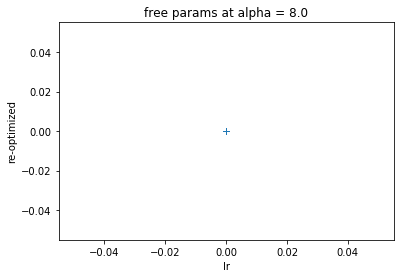

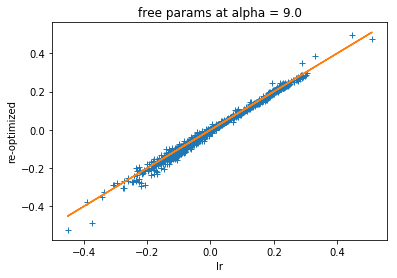

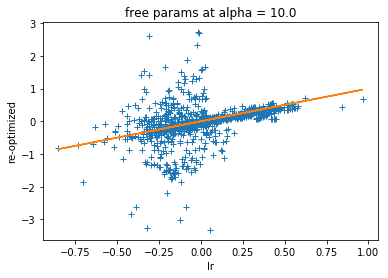

In [19]:
# check results:
for i in range(len(alpha_vec)): 
    plt.figure()
    plt.plot(lr_vb_free_params_array[i, :] - vb_opt_free_params, 
            pert_vb_free_params_array[i, :] - vb_opt_free_params, '+')
    plt.plot(lr_vb_free_params_array[i, :] - vb_opt_free_params, 
            lr_vb_free_params_array[i, :] - vb_opt_free_params, '-')
    
    plt.title('free params at alpha = {}'.format(alpha_vec[i]))
    plt.xlabel('lr')
    plt.ylabel('re-optimized')

# check how vb expectations change

In [20]:
def get_vb_expectations(vb_free_params, vb_params_paragami, true_pop_allele_freq,
                           use_logitnormal_sticks): 
    # get vb dict 
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free=True)
    
    # get popoulation frequencies
    e_pop_allele_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    # find minimizing permutation 
    if e_pop_allele_freq.shape[1] < 6: 
        perm = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)
    else: 
        perm = np.arange(e_pop_allele_freq.shape[1])
    
    # get individual admixutures
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)[:, perm]
    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)
    
    return e_ind_admix, e_pop_allele_freq[:, perm]

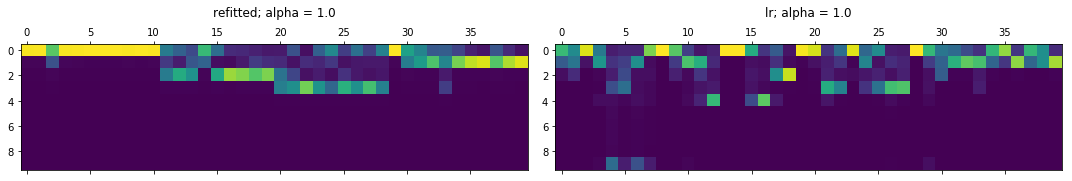

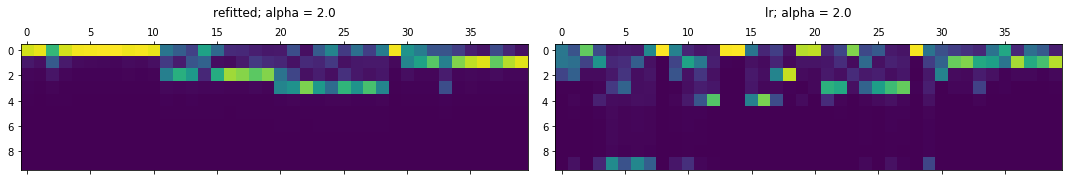

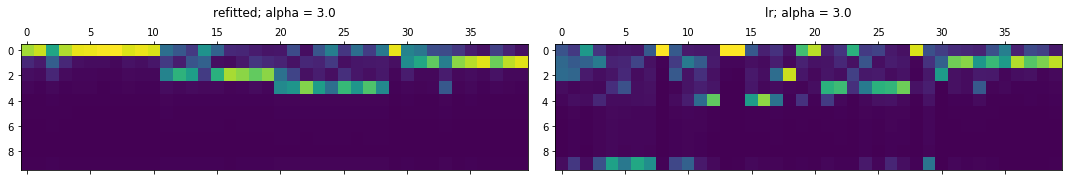

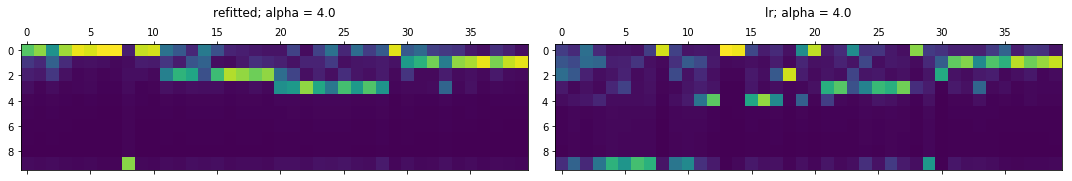

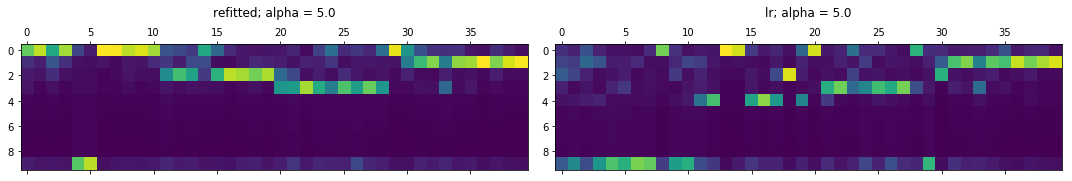

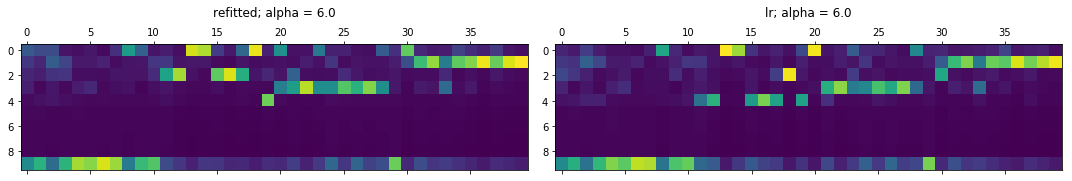

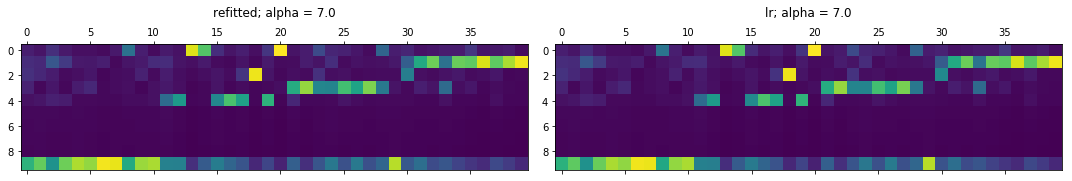

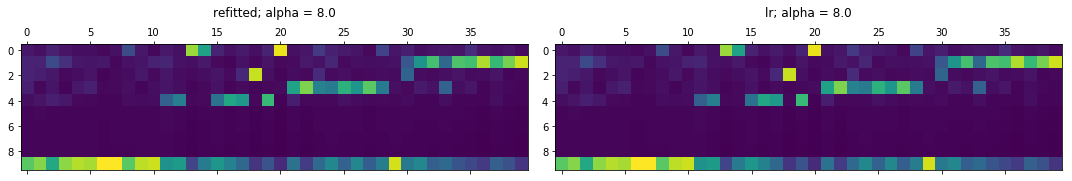

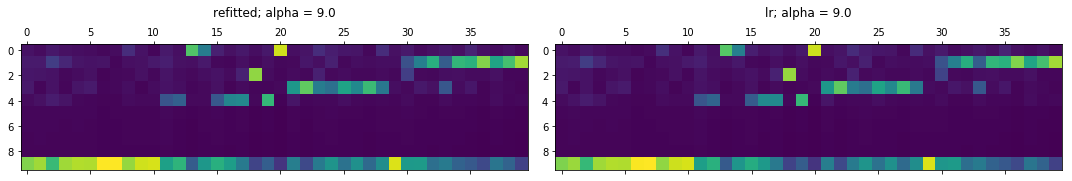

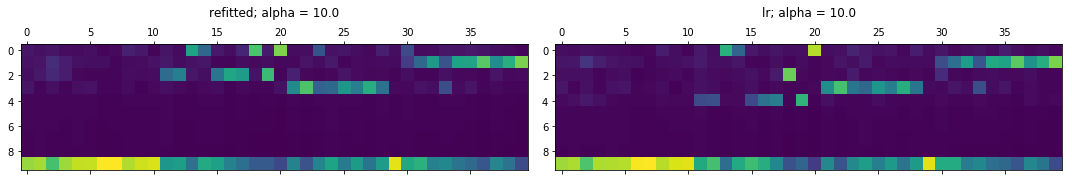

In [21]:
opt_e_ind_admix, opt_e_pop_allele_freq = get_vb_expectations(vb_opt_free_params, 
                                                                vb_params_paragami, 
                                                                true_pop_allele_freq, 
                                                                use_logitnormal_sticks)

pert_e_ind_admix_array = np.zeros((len(alpha_vec), len(opt_e_ind_admix.flatten())))
lr_e_ind_admix_array = np.zeros((len(alpha_vec), len(opt_e_ind_admix.flatten())))

pert_e_pop_allele_freq_array = np.zeros((len(alpha_vec), len(opt_e_pop_allele_freq.flatten())))
lr_e_pop_allele_freq_array = np.zeros((len(alpha_vec), len(opt_e_pop_allele_freq.flatten())))

for i in range(len(alpha_vec)): 
    pert_e_ind_admix, pert_e_pop_allele_freq = \
                    get_vb_expectations(pert_vb_free_params_array[i, :], 
                                        vb_params_paragami, 
                                        true_pop_allele_freq, 
                                        use_logitnormal_sticks)
    
    lr_e_ind_admix, lr_e_pop_allele_freq = \
                    get_vb_expectations(lr_vb_free_params_array[i, :], 
                                        vb_params_paragami, 
                                        true_pop_allele_freq, 
                                       use_logitnormal_sticks)
    
    # plot individual belongings
    _, axarr = plt.subplots(1, 2, figsize = (15, 15))
    axarr[0].matshow(pert_e_ind_admix.T)
    axarr[1].matshow(lr_e_ind_admix.T)
    axarr[0].set_title('refitted; alpha = {}\n'.format(alpha_vec[i]))
    axarr[1].set_title('lr; alpha = {}\n'.format(alpha_vec[i]))
    
    plt.tight_layout()
    
    pert_e_ind_admix_array[i, :] = pert_e_ind_admix.flatten()
    lr_e_ind_admix_array[i, :] = lr_e_ind_admix.flatten()
    
    pert_e_pop_allele_freq_array[i, :] = pert_e_pop_allele_freq.flatten()
    lr_e_pop_allele_freq_array[i, :] = lr_e_pop_allele_freq.flatten()

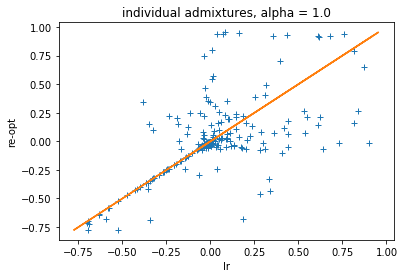

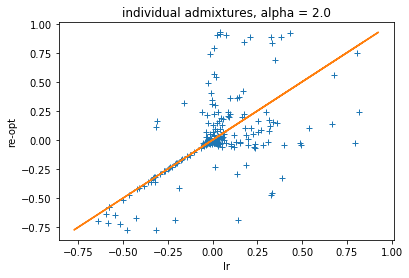

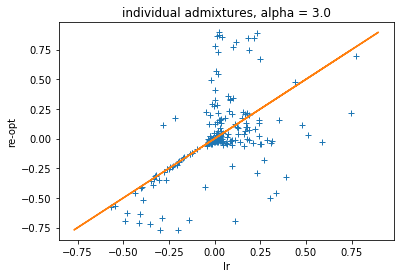

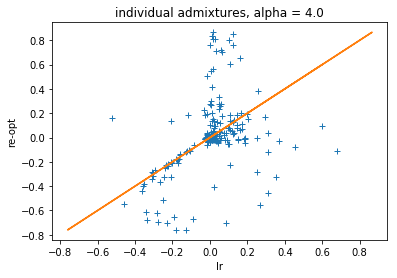

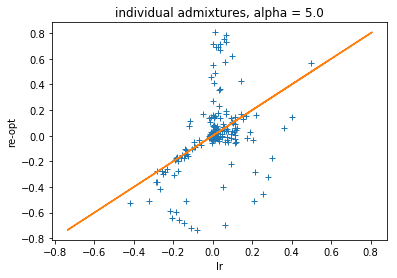

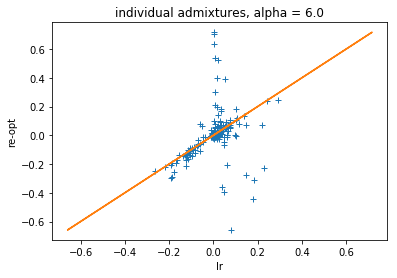

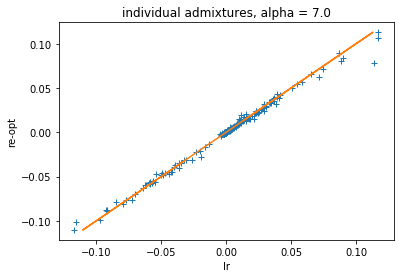

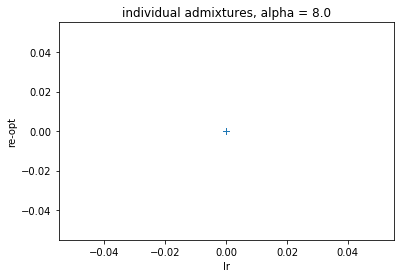

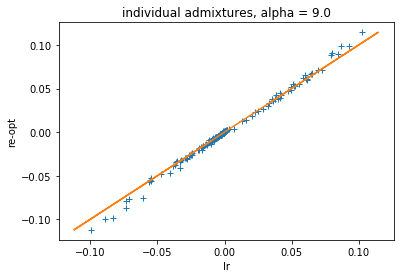

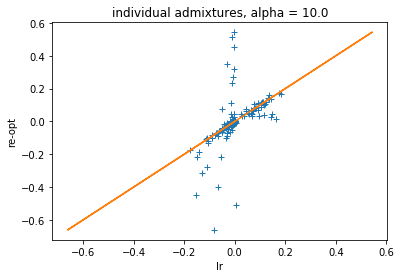

In [22]:
for i in range(len(alpha_vec)): 
    plt.figure()
    plt.plot(lr_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), 
            pert_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), '+')
    plt.plot(pert_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), 
            pert_e_ind_admix_array[i, :] - opt_e_ind_admix.flatten(), '-')
    plt.title('individual admixtures, alpha = {}'.format(alpha_vec[i]))
    
    plt.xlabel('lr')
    plt.ylabel('re-opt')

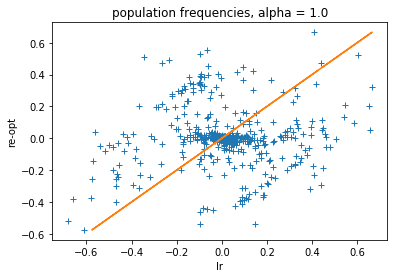

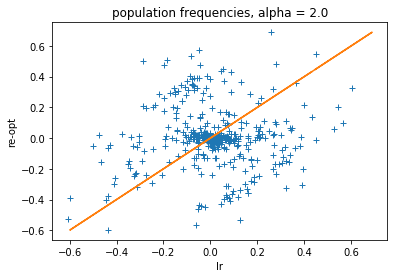

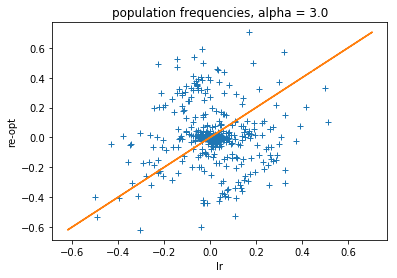

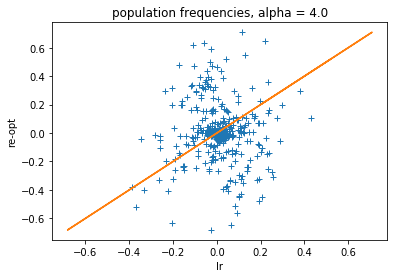

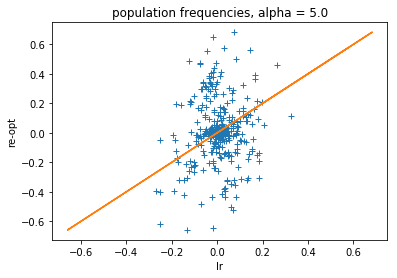

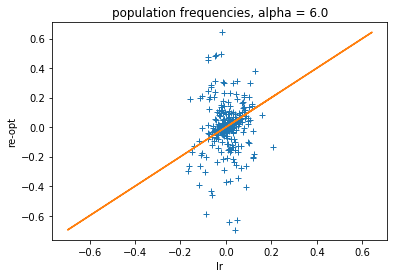

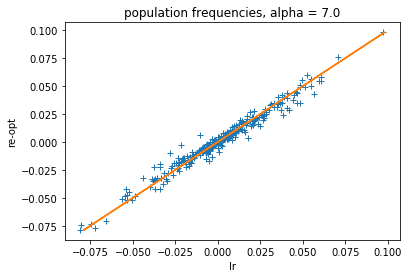

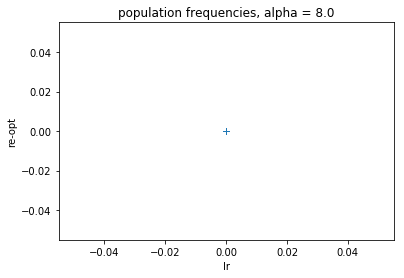

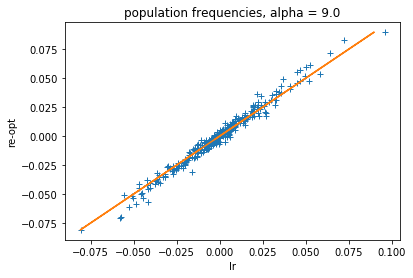

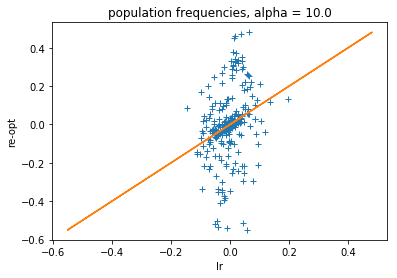

In [23]:
for i in range(len(alpha_vec)): 
    plt.figure()
    plt.plot(lr_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), 
            pert_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), '+')
    plt.plot(pert_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), 
            pert_e_pop_allele_freq_array[i, :] - opt_e_pop_allele_freq.flatten(), '-')
    plt.title('population frequencies, alpha = {}'.format(alpha_vec[i]))
    plt.xlabel('lr')
    plt.ylabel('re-opt')

# Expected number of clusters

In [24]:
n_samples = 10000
unif_samples = np.random.random((n_obs, n_samples))

threshold = 0

In [25]:
e_num_clusters_lr = np.zeros(len(alpha_vec))
e_num_clusters_pert = np.zeros(len(alpha_vec))

for i in range(len(alpha_vec)): 
    # these are individual belongings
    pert_e_ind_admix, _ = \
                    get_vb_expectations(pert_vb_free_params_array[i, :], 
                                        vb_params_paragami, 
                                        true_pop_allele_freq, 
                                        use_logitnormal_sticks)
    
    lr_e_ind_admix, _ = \
                    get_vb_expectations(lr_vb_free_params_array[i, :], 
                                        vb_params_paragami, 
                                        true_pop_allele_freq, 
                                       use_logitnormal_sticks)
    # get expected number of clusters
#     e_num_clusters_lr[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)
#     e_num_clusters_pert[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix)
    
    e_num_clusters_lr[i] = cluster_quantities_lib.get_e_num_large_clusters_from_ez(lr_e_ind_admix,
                                threshold,
                                unif_samples = unif_samples)[0]
    
    e_num_clusters_pert[i] = cluster_quantities_lib.get_e_num_large_clusters_from_ez(pert_e_ind_admix,
                                threshold,
                                unif_samples = unif_samples)[0]

Text(0, 0.5, 'expected number of clusters')

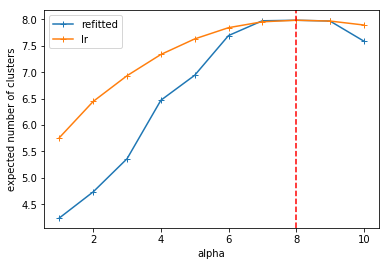

In [26]:
plt.plot(alpha_vec, e_num_clusters_pert, '+-')
plt.plot(alpha_vec, e_num_clusters_lr, '+-')

plt.axvline(x = init_alpha, linestyle = '--', color = 'r')

plt.legend(('refitted', 'lr'))

plt.xlabel('alpha')
plt.ylabel('expected number of clusters')